In [2]:
import sys
import time
import datetime as dt
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import re
import csv
import sklearn
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score as accuracy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
import pylab as pl
import MLpipeline
import string


%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
df = pickle.load(open("df_fin.p", "rb"))
#df_all = pickle.load(open("df_all.p", "rb"))


39,363 observations from Jan 1990 to Feb 2018 (1 or more victims)

In [35]:
df.shape

(39363, 16)

In [4]:
df['mnth_yr'] = pd.to_datetime(df['mnth_yr'])
df['mnth_yr'] = df['mnth_yr'].dt.date

## I. Exploration

In [5]:
def graph_by_year(df, title, factor):
    colors = plt.cm.GnBu(np.linspace(0, 1, len(df[factor].unique())))
    df_gmth = pd.DataFrame({'Count' : df.groupby(['year', factor]).size()}).reset_index()
    df_gmth = df_gmth[df_gmth.Count >=0]
    df_gmth_piv = df_gmth.pivot(index='year', columns=factor, values='Count')
    df_gmth_piv.plot(kind='bar', stacked=True, color = colors)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title)

In [6]:
def monthly_ts(df, title):
    df_gmth = pd.DataFrame({'Count' : df.groupby(['mnth_yr']).size()}).reset_index()
    ax = df_gmth.plot(legend=False)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title)

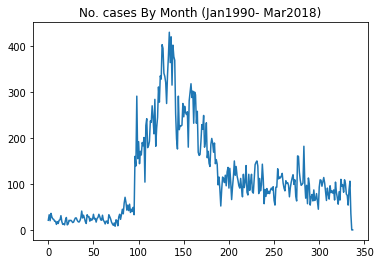

In [7]:
monthly_ts(df, 'No. cases By Month (Jan1990- Mar2018)')


In [3]:
def plot_by_cont_filter(df, factor, word, title):
    '''
    Inputs:
    - df (pd.DataFrame)
    - factor (col)
    - words (list)
    - title (str)
    '''
    
    df_gmth = pd.DataFrame({'Count' : df.groupby(['mnth_yr']).size()}).reset_index()
    df_int = pd.DataFrame({'Dum': df[factor].str.contains(word), 'mnth_yr': df['mnth_yr']})
    df_intc = df_int.groupby(['mnth_yr']).sum().reset_index()
    df_gmth['int'] = df_intc.Dum
    df_gmth['int_rat'] = df_gmth['int'] / df_gmth['Count']
    ax = df_gmth.int_rat.plot()
    plt.title(title)
    return df_gmth

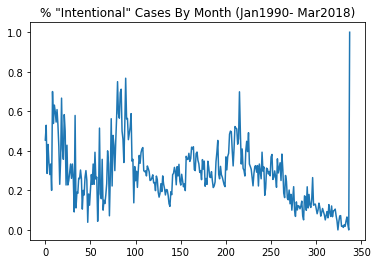

In [277]:
dm = plot_by_cont_filter(df, 'Type', 'INTENCIONAL', '% "Intentional" Cases By Month (Jan1990- Mar2018)')


Note: there is only one observation for Mar2018, and it is labelled as intentional, hence the "spike".

## II. Classification (word frequency analysis)

In [144]:
user_defined_stop_words = ['a', 'ante', 'con', 'de','por','si','la', 'en' , 'el', 'que', 'del', 'los' , 'y',
                           'las', 'para', 'uno', 'una', 'unos', 'como', 'los', 'fue', 'al', 'su', 'se', 'un', 
                           'lo','no'] 
#i = nltk.corpus.stopwords.words('spanish')
stopwords = list(string.punctuation) + user_defined_stop_words


Conditional probability based on word frequencies  relative to the whole "vocabulary" (i.e. the set of all words in the descriptions) and Bayes Rule.<br>
__Goal__: obtain the  words that are strongly predictive of label 'INTENTIONAL':

In [170]:
nb2 = MultinomialNB(alpha=1, fit_prior=False)
nb2.fit(X_train, Y_train)
preds2 = nb1.predict(X_test)

In [177]:
count_vect.get_feature_names()
nb2.classes_
top50 = sorted(zip(nb2.coef_[0], count_vect.get_feature_names()))[-50:]

Most predictive words (stemmed from their roots). Lower coefficient = more predictive:

In [178]:
top50

[(-5.926192827254556, 'arma'),
 (-5.9150195266564305, 'pm'),
 (-5.899752054525642, 'dieron'),
 (-5.888868732368249, 'farcep'),
 (-5.88803643935308, 'era'),
 (-5.872353080337528, 'ubic'),
 (-5.867451109737321, 'da'),
 (-5.848879724151886, 'correg'),
 (-5.795149401730918, 'fuent'),
 (-5.788349224411854, 'este'),
 (-5.783841327972664, 'lueg'),
 (-5.782343200351642, 'miembr'),
 (-5.771918683015757, 'hombr'),
 (-5.734837008111226, 'cas'),
 (-5.706685958448711, 'cuand'),
 (-5.6990813590634914, 'dond'),
 (-5.697017374842639, 'qui'),
 (-5.696330325691601, 'polic'),
 (-5.690850859926976, 'tres'),
 (-5.664560164695258, 'zon'),
 (-5.6158650530424135, 'edad'),
 (-5.589597126221803, 'present'),
 (-5.584671007885747, 'barri'),
 (-5.56039797152954, 'nacional'),
 (-5.543750738096384, 'encontr'),
 (-5.523323999272024, 'impact'),
 (-5.486461305586087, 'haci'),
 (-5.484236610563976, 'asesin'),
 (-5.47153977976957, 'sus'),
 (-5.45037209661122, 'comun'),
 (-5.419698089426405, 'ejrcit'),
 (-5.41554007927774

## III. Additional Columns

Add the following columns, based on description texts:
- Weapon type (firegun, explosives, knife, machine-gun / large scale, unknown; can take multiple values)
- Number of victims (integer)
- Presence of torture (dummy)
- Presence of threat (dummy)
- Murder (dummy)
- Type of victim:
 - Government official (dummy)
 - Civic leader (dummy)
 - Farmer (dummy)



In [8]:
def weapon(text, d):
    weaps= set()
    for weap, wlist in d.items():
        for w in wlist:
            if w in text:
                weaps.add(weap)
    if len(weaps) == 0:
        return 'unknown'
    else:
        return str(list(weaps))

In [9]:
def torture(text):
    words = ['tortur', 'golp', 'mutil', 'quema', 'quemó']
    for w in words:
        if w in text:
            return 1
        else:
            return 0

In [10]:
def threat(text):
    words = ['amenaz', 'advert', 'advirt', 'avis', 'pregunt', 'señal', 'veng', ' sapo']
    for w in words:
        if w in text:
            return 1
        else:
            return 0

In [13]:
def gov_vict(text):
    words = ['funcionario', ' municip', 'jefat', 'fisc','alcald', 'presiden', 'autorid',\
             ' palacio', 'procurador',  'juez', ' oficial', ' gob', 'candidat', 'Minist','\
             ministr' , 'Partido', 'Fiscal', 'Presid', 'Procurad']
    for w in words:
        if w in text:
            return 1
        else:
            return 0

In [14]:
def civ_leader(text):
    words = [' líder', 'lider', 'comisi',' civil', ' ciudadan', 'concej', ' consej', \
             ' sindic', 'Sindic' , 'gremi', 'Junta', 'Asocia', 'Concej', ' sacerd', ' relig',\
            'Organiz', 'dirigent', 'profes', 'maestr', 'director' ]
    for w in words:
        if w in text:
            return 1
        else:
            return 0

In [15]:
def camp(text):
    words = ['Campes', 'campes', 'Hacend', 'hacend', 'agricult', 'ganade', 'Ganad']
    for w in words:
        if w in text:
            return 1
        else:
            return 0

In [33]:
regex_pat = re.compile(r'\:(.*)', flags=re.IGNORECASE)
df['num_vict'] = df.Victim.str.extract(regex_pat)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [34]:
armas = {'firegun':[' tiro', 'pistol', 'bala', 'bale', 'arma de fueg', 'ejecu', \
                    'disp', 'rifl'], 'explosives': ['bomb', 'explo', 'dinamit', \
                    'granad', 'deton'], 'machine gun / large capacity': ['metrall', 'escopet'], 'knive':['cuchill', 'navaj', ' cortad',' cortar', 'cortó', ' apuñ', ' decapit']}
df['weapon'] = df['Description'].apply(weapon, args=(armas,))

In [74]:
df['torture'] = df['Description'].apply(torture)

In [75]:
df['threat'] = df['Description'].apply(threat)

In [76]:
df['gov_vict'] = df['Description'].apply(gov_vict)

In [77]:
df['murder'] = df['Type'].str.contains('HOMICIDIO')
df['murder'] = np.where(df['murder']== True, 1, 0)

In [78]:
df['civ_leader'] = df['Description'].apply(civ_leader)

In [79]:
df['camp_vict'] = df['Description'].apply(camp)

In [80]:
df['int'] = df['Type'].str.contains('INTENCIONAL')
df['int'] = np.where(df['int']== True, 1, 0)

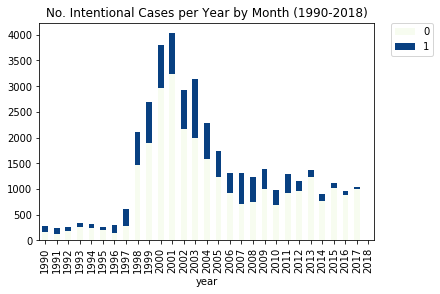

In [81]:
graph_by_year(df, title = "No. Intentional Cases per Year by Month (1990-2018)", factor= 'int')

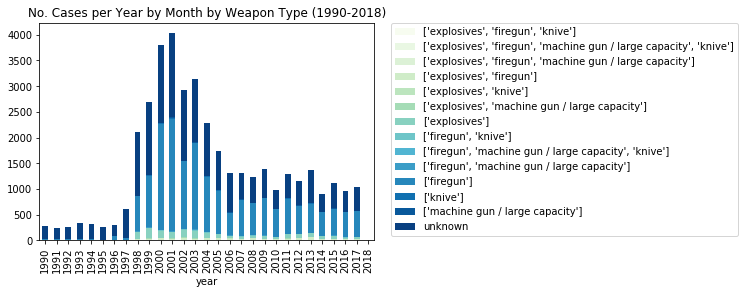

In [82]:
graph_by_year(df, title = "No. Cases per Year by Month by Weapon Type (1990-2018)", factor= 'weapon')

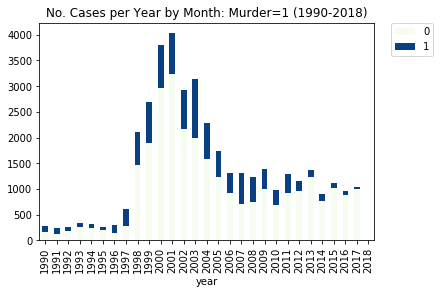

In [83]:
graph_by_year(df, title = "No. Cases per Year by Month: Murder=1 (1990-2018)", factor= 'murder')

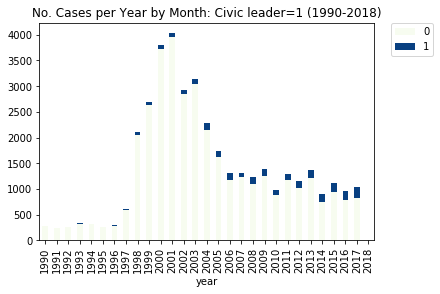

In [84]:
graph_by_year(df, title = "No. Cases per Year by Month: Civic leader=1 (1990-2018)", factor= 'civ_leader')

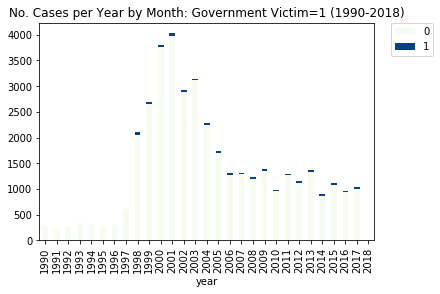

In [85]:
graph_by_year(df, title = "No. Cases per Year by Month: Government Victim=1 (1990-2018)", factor= 'gov_vict')

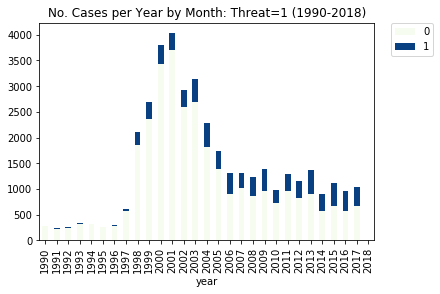

In [86]:
graph_by_year(df, title = "No. Cases per Year by Month: Threat=1 (1990-2018)", factor= 'threat')

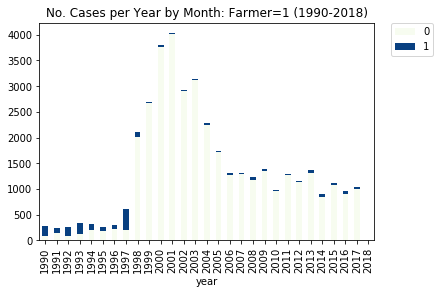

In [87]:
graph_by_year(df, title = "No. Cases per Year by Month: Farmer=1 (1990-2018)", factor= 'camp_vict')

##  IV. "Intentional" random sample

From the observations labelled as 'INTENTIONAL' in the original dataset (10,420), we randomly pick 20, in order to inspect their associated description:

In [64]:
df_int_sample = df[df['int'] == 1].sample(20)
df_int_sample.head()

,Description,Date,Location,Victim,Alleged_Responsible,Type,year,month,mnth_yr,Dep_name,...,Pob_code,num_vict,weapon,torture,threat,gov_vict,murder,civ_leader,camp_vict,int
2184,Campesinos asesinados por un grupo paramilitar...,1997-01-10,CESAR / EL PASO,"FRANCISCO LÓPEZ MACHADO A10, D701, ARISTIDES...",PARAMILITARES,"PERSECUCIÓN POLÍTICA:EJECUCIÓN EXTRAJUDICIAL,...",1997,January,1997-01-01,CESAR,...,NaN,3,unknown,0,0,0,1,0,1,1
20103,Paramilitares que adelantaban un retén ilegal ...,2010-03-08,CÓRDOBA / PLANETA RICA,"LENES RIOS JUAN (1966) A10, D701, GONZÁLEZ CAU...",PARAMILITARES,"PERSECUCIÓN POLÍTICA:EJECUCIÓN EXTRAJUDICIAL,...",2010,March,2010-03-01,CÓRDOBA,...,NaN,2,['firegun'],0,0,0,1,0,0,1
13634,Tropas del Ejército Nacional ejecutaron al ind...,2005-01-06,ARAUCA / FORTUL / FORTUL; ARAUCA / FORTUL,"ANTONIO CHANEQUE A10, D701 | Víctimas Ind:1",EJERCITO,"PERSECUCIÓN POLÍTICA:EJECUCIÓN EXTRAJUDICIAL,...",2005,January,2005-01-01,ARAUCA,...,NaN,1,['firegun'],0,0,0,1,0,0,1
16783,Paramilitares que actúan libre e impunemente e...,2008-01-06,META / PUERTO LLERAS,"BELZAR SANCHEZ A10, D701, ARIANNA SANCHEZ ME...",PARAMILITARES,"PERSECUCIÓN POLÍTICA:EJECUCIÓN EXTRAJUDICIAL,...",2008,January,2008-01-01,META,...,NaN,2,unknown,0,1,0,1,0,0,1
23992,Paramilitares ejecutaron con arma de fuego a J...,2014-01-15,SANTANDER / BARRANCABERMEJA,"CORREA CASTAÑEDA JORGE ALBERTO (1995) A10, D70...",PARAMILITARES,"PERSECUCIÓN POLÍTICA:EJECUCIÓN EXTRAJUDICIAL,...",2014,January,2014-01-01,SANTANDER,...,NaN,1,['firegun'],0,0,0,1,0,0,1


In [65]:
for i in range(len(df_int_sample)):
    print('Obs ' + str(i) +':', '\n', df_int_sample.iloc[i]['Description'], '\n')

Obs 0: 
 Campesinos asesinados por un grupo paramilitar en el corregimiento Cuatro Vientos 

Obs 1: 
 Paramilitares que adelantaban un retén ilegal en la vía que del casco urbano de Planeta Rica conduce al corregimiento de Marañonal, en la vereda Punta Verde, interceptaron el vehículo de servicio público en el que se transportaba  Juan Lenes Ríos, de 44 años de edad, ingresaron por la fuerza al mismo y dispararon contra su humanidad lo que le causó la muerte. De igual forma dispararon contra el conductor  Rosendo González Causil, quien resultó herido. Personas que transitaban por la vía descubrieron los cuerpos y de inmediato dieron aviso a las autoridades de la localidad, al tiempo que auxiliaron al herido, quien fue trasladado a un centro asistencial de la capital cordobesa. El levantamiento del cadáver fue realizado por las autoridades judiciales. La víctima mortal se supo que era natural de Cartagena, Bolívar, y vivía en el corregimiento Centro Alegre, donde se dedicaba al oficio d